In [1]:
%config Completer.use_jedi=False

In [26]:
!conda install -y seaborn


^C


In [27]:
import tensorflow as tf
import seaborn as sns

In [3]:
def get_vgg_features(input):
    vgg=tf.keras.applications.VGG16()
    # Inputs to a layer should be tensors
    f2=vgg.get_layer('block2_pool').output
    f3=vgg.get_layer('block3_pool').output
    f4=vgg.get_layer('block4_pool').output
    f5=vgg.get_layer('block5_pool').output
    f1=vgg.get_layer('block1_pool').output
    f2=vgg.get_layer('block2_pool').output
    f3=vgg.get_layer('block3_pool').output
    f4=vgg.get_layer('block4_pool').output
    f5=vgg.get_layer('block5_pool').output
#     f1=vgg.get_layer('block1_pool')
#     f2=vgg.get_layer('block2_pool')
#     f3=vgg.get_layer('block3_pool')
#     f4=vgg.get_layer('block4_pool')
#     f5=vgg.get_layer('block5_pool')
    return (vgg.input,(f1,f2,f3,f4,f5))

In [4]:
def get_fcn_32(convs):
    f1,f2,f3,f4,f5=convs
    o = tf.keras.layers.Conv2DTranspose(12 , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
    o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)
    o = tf.keras.layers.Conv2DTranspose(12 , kernel_size=(16,16) ,  strides=(16,16) , use_bias=False )(o)

    # append a softmax to get the class probabilities
    o = (tf.keras.layers.Activation('softmax'))(o)

    return o

In [5]:
def get_model():
    input=tf.keras.layers.Input((224,224,3))
    input,convs=get_vgg_features(input)
    output=get_fcn_32(convs)
    model=tf.keras.Model(inputs=input,outputs=output)
    return model

In [6]:
mymodel=get_model()

In [7]:




mymodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
#import seaborn as sns

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.0


In [9]:
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'byciclist', 'void']

In [10]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=224, width=224):
  '''
  Preprocesses the dataset by:
    * resizing the input image and label maps
    * normalizing the input image pixels
    * reshaping the label maps from (height, width, 1) to (height, width, 12)

  Args:
    t_filename (string) -- path to the raw input image
    a_filename (string) -- path to the raw annotation (label map) file
    height (int) -- height in pixels to resize to
    width (int) -- width in pixels to resize to

  Returns:
    image (tensor) -- preprocessed image
    annotation (tensor) -- preprocessed annotation
  '''

  # Convert image and mask files to tensors 
  img_raw = tf.io.read_file(t_filename)
  anno_raw = tf.io.read_file(a_filename)
  image = tf.image.decode_jpeg(img_raw)
  annotation = tf.image.decode_jpeg(anno_raw)
 
  # Resize image and segmentation mask
  image = tf.image.resize(image, (height, width,))
  annotation = tf.image.resize(annotation, (height, width,))
  image = tf.reshape(image, (height, width, 3,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  annotation = tf.reshape(annotation, (height, width, 1,))
  stack_list = []

  # Reshape segmentation masks
  for c in range(len(class_names)):
    mask = tf.equal(annotation[:,:,0], tf.constant(c))
    stack_list.append(tf.cast(mask, dtype=tf.int32))
  
  annotation = tf.stack(stack_list, axis=2)

  # Normalize pixels in the input image
  image = image/127.5
  image -= 1

  return image, annotation

In [11]:
# Utilities for preparing the datasets

BATCH_SIZE = 12

def get_dataset_slice_paths(image_dir, label_map_dir):
  '''
  generates the lists of image and label map paths
  
  Args:
    image_dir (string) -- path to the input images directory
    label_map_dir (string) -- path to the label map directory

  Returns:
    image_paths (list of strings) -- paths to each image file
    label_map_paths (list of strings) -- paths to each label map
  '''
  image_file_list = os.listdir(image_dir)
  label_map_file_list = os.listdir(label_map_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
  label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]

  return image_paths, label_map_paths


def get_training_dataset(image_paths, label_map_paths):
  '''
  Prepares shuffled batches of the training set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the train set
    label_map_paths (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  training_dataset = training_dataset.map(map_filename_to_image_and_mask)
  training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


def get_validation_dataset(image_paths, label_map_paths):
  '''
  Prepares batches of the validation set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the val set
    label_map_paths (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()  

  return validation_dataset


In [12]:
# get the paths to the images
training_image_paths, training_label_map_paths = get_dataset_slice_paths('fcnn-dataset/dataset1/images_prepped_train/','fcnn-dataset/dataset1/annotations_prepped_train/')
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths('fcnn-dataset/dataset1/images_prepped_test/','fcnn-dataset/dataset1/annotations_prepped_test/')

# generate the train and val sets
training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)

In [13]:
sgd = tf.keras.optimizers.SGD(lr=1E-2, momentum=0.9, nesterov=True)

mymodel.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

C:\Users\AbhijitShingote\.conda\envs\tf2.6_092021\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
BATCH_SIZE

12

In [15]:
# number of training images
train_count = 367

# number of validation images
validation_count = 101

EPOCHS = 170

steps_per_epoch = train_count//BATCH_SIZE
validation_steps = validation_count//BATCH_SIZE

history = mymodel.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

Epoch 1/170
30/30 [==============================] - 26s 473ms/step - loss: 2.4850 - accuracy: 0.0818 - val_loss: 2.4846 - val_accuracy: 0.0872
Epoch 2/170
30/30 [==============================] - 18s 449ms/step - loss: 2.4838 - accuracy: 0.0918 - val_loss: 2.4830 - val_accuracy: 0.0989
Epoch 3/170
30/30 [==============================] - 13s 446ms/step - loss: 2.4809 - accuracy: 0.1079 - val_loss: 2.4784 - val_accuracy: 0.1174
Epoch 4/170
30/30 [==============================] - 13s 449ms/step - loss: 2.4642 - accuracy: 0.1372 - val_loss: 2.4183 - val_accuracy: 0.1576
Epoch 5/170
30/30 [==============================] - 14s 452ms/step - loss: 2.1852 - accuracy: 0.2670 - val_loss: 1.9153 - val_accuracy: 0.2910
Epoch 6/170
30/30 [==============================] - 14s 454ms/step - loss: 1.7257 - accuracy: 0.3203 - val_loss: 1.7419 - val_accuracy: 0.2971
Epoch 7/170
30/30 [==============================] - 13s 449ms/step - loss: 1.5386 - accuracy: 0.4056 - val_loss: 1.4780 - val_accuracy:

30/30 [==============================] - 13s 448ms/step - loss: 0.3927 - accuracy: 0.8894 - val_loss: 0.4904 - val_accuracy: 0.8605
Epoch 58/170
30/30 [==============================] - 13s 447ms/step - loss: 0.3880 - accuracy: 0.8906 - val_loss: 0.4839 - val_accuracy: 0.8602
Epoch 59/170
30/30 [==============================] - 13s 447ms/step - loss: 0.3881 - accuracy: 0.8904 - val_loss: 0.4927 - val_accuracy: 0.8577
Epoch 60/170
30/30 [==============================] - 14s 452ms/step - loss: 0.3858 - accuracy: 0.8917 - val_loss: 0.4868 - val_accuracy: 0.8594
Epoch 61/170
30/30 [==============================] - 13s 447ms/step - loss: 0.3781 - accuracy: 0.8939 - val_loss: 0.4952 - val_accuracy: 0.8582
Epoch 62/170
30/30 [==============================] - 13s 448ms/step - loss: 0.3800 - accuracy: 0.8928 - val_loss: 0.4923 - val_accuracy: 0.8605
Epoch 63/170
30/30 [==============================] - 14s 453ms/step - loss: 0.3781 - accuracy: 0.8936 - val_loss: 0.4896 - val_accuracy: 0.863

30/30 [==============================] - 13s 451ms/step - loss: 0.2924 - accuracy: 0.9174 - val_loss: 0.5422 - val_accuracy: 0.8586
Epoch 114/170
30/30 [==============================] - 13s 449ms/step - loss: 0.2939 - accuracy: 0.9175 - val_loss: 0.5362 - val_accuracy: 0.8607
Epoch 115/170
30/30 [==============================] - 14s 455ms/step - loss: 0.2932 - accuracy: 0.9180 - val_loss: 0.5433 - val_accuracy: 0.8617
Epoch 116/170
30/30 [==============================] - 14s 451ms/step - loss: 0.2861 - accuracy: 0.9199 - val_loss: 0.5327 - val_accuracy: 0.8644
Epoch 117/170
30/30 [==============================] - 13s 451ms/step - loss: 0.2873 - accuracy: 0.9193 - val_loss: 0.5514 - val_accuracy: 0.8605
Epoch 118/170
30/30 [==============================] - 14s 452ms/step - loss: 0.2927 - accuracy: 0.9176 - val_loss: 0.5337 - val_accuracy: 0.8630
Epoch 119/170
30/30 [==============================] - 13s 451ms/step - loss: 0.2887 - accuracy: 0.9188 - val_loss: 0.5431 - val_accuracy:

30/30 [==============================] - 13s 447ms/step - loss: 0.2562 - accuracy: 0.9278 - val_loss: 0.6100 - val_accuracy: 0.8590
Epoch 170/170
30/30 [==============================] - 13s 448ms/step - loss: 0.2562 - accuracy: 0.9280 - val_loss: 0.6098 - val_accuracy: 0.8586


In [16]:
def get_images_and_segments_test_arrays():
  '''
  Gets a subsample of the val set as your test set

  Returns:
    Test set containing ground truth images and label maps
  '''
  y_true_segments = []
  y_true_images = []
  test_count = 64

  ds = validation_dataset.unbatch()
  ds = ds.batch(101)

  for image, annotation in ds.take(1):
    y_true_images = image
    y_true_segments = annotation


  y_true_segments = y_true_segments[:test_count, : ,: , :]
  y_true_segments = np.argmax(y_true_segments, axis=3)  

  return y_true_images, y_true_segments

# load the ground truth images and segmentation masks
y_true_images, y_true_segments = get_images_and_segments_test_arrays()

In [18]:
# get the model prediction
results = mymodel.predict(validation_dataset, steps=validation_steps)

# for each pixel, get the slice number which has the highest probability
results = np.argmax(results, axis=3)

In [19]:
def compute_metrics(y_true, y_pred):
  '''
  Computes IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label map
    y_pred (tensor) - predicted label map
  '''
  
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001

  for i in range(12):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

In [21]:
# Visualization Utilities

def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Args:
    images (list of numpy arrays) - numpy array representations of the images to paste
  
  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]
  
  return new_im


def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array
  
  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(12):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img


def show_predictions(image, labelmaps, titles, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps

  Args:
    image (numpy array) -- the input image
    labelmaps (list of arrays) -- contains the predicted and ground truth label maps
    titles (list of strings) -- display headings for the images to be displayed
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each vlass
  '''

  true_img = give_color_to_annotation(labelmaps[1])
  pred_img = give_color_to_annotation(labelmaps[0])

  image = image + 1
  image = image * 127.5
  images = np.uint8([image, pred_img, true_img])

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list) 

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.title(titles[idx], fontsize=12)
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)
  
  image = image + 1
  image = image * 127.5
  image = np.uint8(image)
  images = [image, seg_img]
  
  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset):
  '''
  Displays images and its annotations side by side

  Args:
    dataset (tf Dataset) - batch of images and annotations
  '''

  ds = dataset.unbatch()
  ds = ds.shuffle(buffer_size=100)

  plt.figure(figsize=(25, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  # we set the number of image-annotation pairs to 9
  # feel free to make this a function parameter if you want
  for idx, (image, annotation) in enumerate(ds.take(9)):
    plt.subplot(3, 3, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())

 

In [28]:
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))

# print class name - normalized RGB tuple pairs
# the tuple values will be multiplied by 255 in the helper functions later
# to convert to the (0,0,0) to (255,255,255) RGB values you might be familiar with
for class_name, color in zip(class_names, colors):
  print(f'{class_name} -- {color}')

sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
byciclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


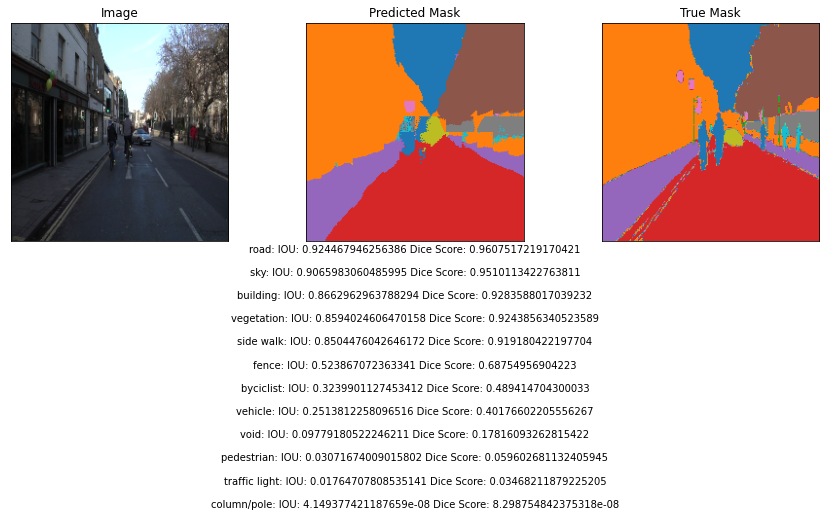

In [33]:
# input a number from 0 to 63 to pick an image from the test set
integer_slider = 10

# compute metrics
iou, dice_score = compute_metrics(y_true_segments[integer_slider], results[integer_slider])  

# visualize the output and metrics
show_predictions(y_true_images[integer_slider], [results[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou, dice_score)

In [30]:
# compute class-wise metrics
cls_wise_iou, cls_wise_dice_score = compute_metrics(y_true_segments, results)


ValueError: operands could not be broadcast together with shapes (96,224,224) (64,224,224) 

In [34]:
# print IOU for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (13-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou)) 

NameError: name 'cls_wise_iou' is not defined

In [ ]:
# print the dice score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (13-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score)) 
